# Introduction and Imports 📔

Let's get started with this new image competition! 
Below is a brief introduction to it as well as the data files present here!

* Edit:
I recently wrote a notebook where I am <strong style="color:'green'"><a href="https://www.kaggle.com/heyytanay/finding-similar-images-using-image-deduplicator">Finding Similar Products using Image De-duplicator 📸</a></strong>, you can check it out to see a possible Image based solution to this challenge.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob
import random

from rich import print as _pprint

In [2]:
def cprint(string):
    """
    Utility function for beautiful colored printing.
    """
    _pprint(f"[black]{string}[/black]")

## What is our task? 🎯

Ok, so in this competition we are provided with images of different products posted by users on the platform, **Shopee** and our task is to identify if two (or more) posted products are same.

During inference, we will be provided with `posting_id`, image name (`image`), `image_phash` (perceptual hash of the image) and the `title` of the image.
And out task will be to find **at-most 49 matching images** to the one currently in question.

This is a Code-Competition and hence only 3 samples are currently in the test set but the model will be evaluated on more samples (about *70K images*) privately when submitted.
The submission file should consist of 2 rows:
* `posting_id`: The Posting Id of the image (taken from the test file)
* `matches`: All the different matches to the current image by their posting id. Keep in mind, all images are a self match for first (i.e: all images also match themselves, so you would have to include that in your entry too). Different posting ids will be separated by space.

<hr>

## How does the Data look like? 🗃

So, the data provided to us in this competition consists of 3 `.csv` files and 2 folders (`training_images` and `testing_images`).

Below is the breakdown of the `.csv` files and image folders;

* 📄 `train.csv` - This is the Training set metadata. Each row contains the data for a single posting. Multiple postings might have the exact same image ID, but with different titles or vice versa.


* 📄 `test.csv` - Same as `train.csv` except the `label_group` column. This file will be what we are going to use at inference time. Currently it only consists of 3 samples but it will be replaced by a bigger private test set at submission time.


* 📄 `sample_submission.csv` - The Sample submission file in the format we are expected to follow.


* 📂 `train_images/` - Folder with all the training images.


* 📂 `test_images/` - Folder with all the testing images (again, only 4 images for now, but will be around ~70,000 images during submission)

<hr>

## Evaluation Metric ✒

In this competition, our submissions will be judged on F1 Score metric.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 

The relative contribution of precision and recall to the F1 score are equal.

$$F1 = \frac{2 \cdot precision\cdot recall}{precision+ recall}$$

where,

$$precision=\frac{True Positive}{True Positive + False Positive}$$
<br>
$$recall=\frac{True Positive}{True Positive + False Negative}$$

<hr>

## Peeking at the Data 📈

Now that you have an understanding of the task and the dataset, let's start by looking at the different data files provided and some stats!

In [3]:
train_file = pd.read_csv("../input/shopee-product-matching/train.csv")
train_file

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group  
0        249114794  
1       2937985045  
2       2395904891  
3       4093212188  
4       3648931069  
...            ...  
34245   3776555725  
34246   2736479533  
34247   4101248785  
34248   1663538013  
34249    459464107  

[34250 rows x 5 columns]

In [4]:
test_file = pd.read_csv("../input/shopee-product-matching/test.csv")
test_file.head()

posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...  
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...  
2   READY Lemonilo Mie instant sehat kuah dan goreng

In [5]:
sample_sub = pd.read_csv("../input/shopee-product-matching/sample_submission.csv")
sample_sub.head()

posting_id          matches
0  test_2255846744  test_2255846744
1  test_3588702337  test_3588702337
2  test_4015706929  test_4015706929

In [6]:
total_train_files = glob.glob("../input/shopee-product-matching/train_images/*.jpg")
total_test_files = glob.glob("../input/shopee-product-matching/test_images/*.jpg")

cprint(f"[green]Total Training Images: {len(total_train_files)}[/green]")
cprint(f"[red]Total Testing Images: {len(total_test_files)}[/red]")

Total Training Images: 32412

Total Testing Images: 3

<hr>

# Image EDA 📸

Now, let's move to the EDA part and get started by looking at images randomly from the dataset and from different groups.

In [7]:
def plot(num):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num), "Number of Images must be a perfect Square!"

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(IMG_PATHS + '/' + image_ids[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img); ax[i, j].set_title(f'{image_ids[idx]}', fontsize=6.5)

    plt.show()
    
    
def plot_from_label(group):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    image_list = train_file[train_file['label_group'] == group]
    image_list = image_list['image'].tolist()
    num = len(image_list)
    
    sq_num = np.sqrt(num)

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))
    
    path = [os.path.join(IMG_PATHS, x) for x in image_list]
    
    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(path[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img)

    plt.show()

def plot_from_title(title):
    IMG_PATHS = "../input/shopee-product-matching/train_images/"
    image_list = train_file[train_file['title'] == title]
    image_list = image_list['image'].tolist()
    num = len(image_list)
    
    sq_num = np.sqrt(num)
    sq_num = int(sq_num)
    
    image_ids = os.listdir(IMG_PATHS)
    random.shuffle(image_ids)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(10, 10))
    fig.suptitle(f"Product Name: {title}")
    path = [os.path.join(IMG_PATHS, x) for x in image_list]
    
    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(path[idx])
            img = img[:, :, ::-1]
            ax[i, j].imshow(img)
            
    plt.show()

## Plotting Products Naively

Let's start Image EDA by plotting the products just randomly from the dataset.

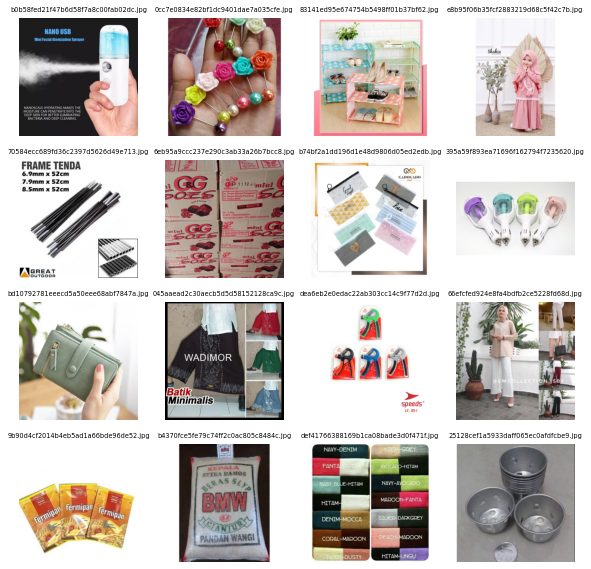

In [8]:
# Plot 16 random images
plot(16)

## Plotting Products based on Image Label Group

Let's take a little smarter approach by plotting products based on their label group.

**Image Label Group: 1141798720**

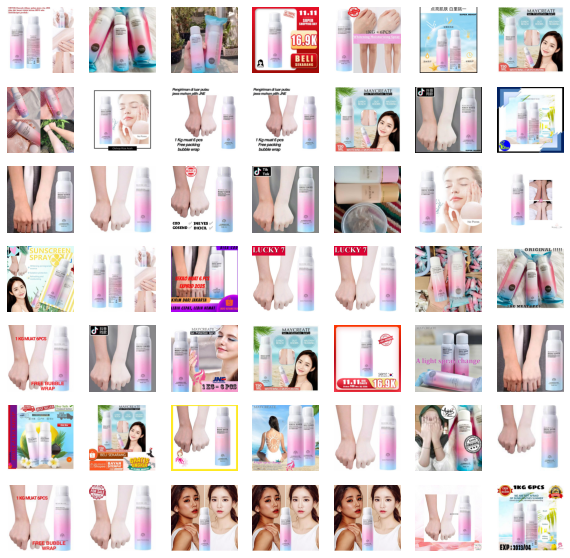

In [9]:
plot_from_label(1141798720)

**Image Label group: 994676122**

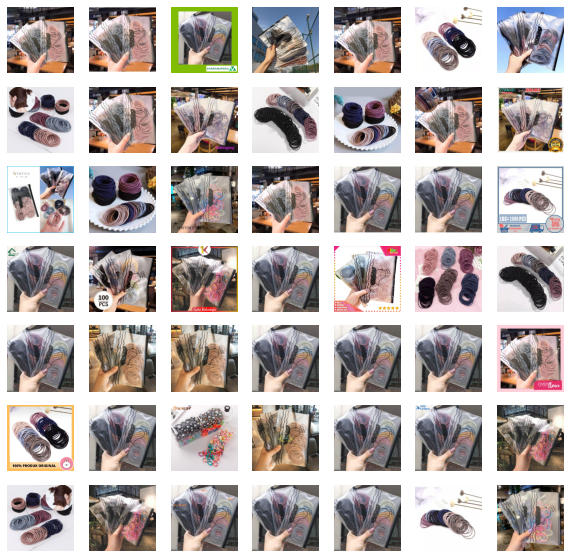

In [10]:
plot_from_label(994676122)

## Product Images with Same Name

Now let's see some product images that have same name (title). 

This will help us see how the images with same title can be different from each other.

**Title: Koko syubbanul muslimin koko azzahir koko baju**

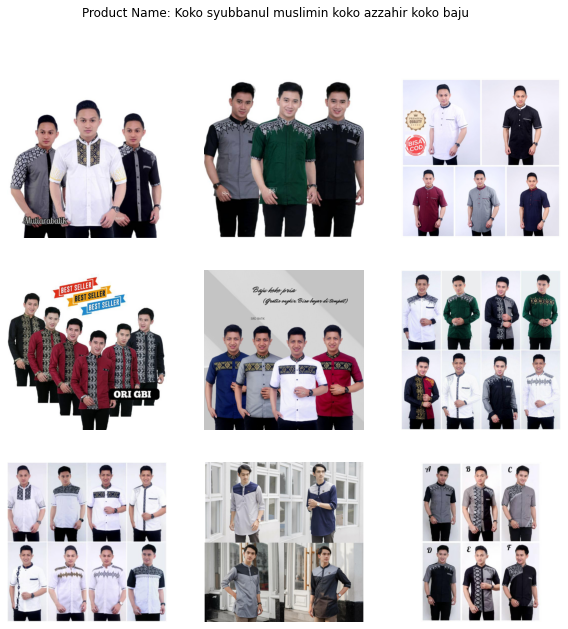

In [11]:
plot_from_title("Koko syubbanul muslimin koko azzahir koko baju")

**Title: Monde Boromon Cookies 1 tahun+ 120gr**

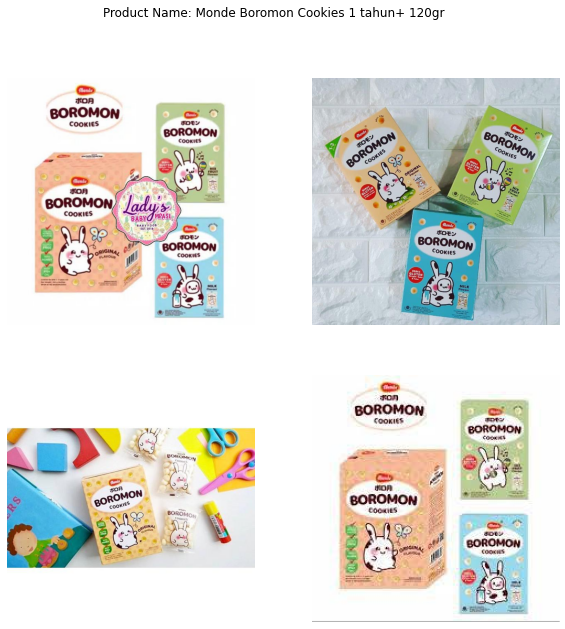

In [13]:
plot_from_title("Monde Boromon Cookies 1 tahun+ 120gr")

<hr>

## Top-15 Image Label Groups

Let's see the top-15 image label groups (by the number of images) in this dataset.

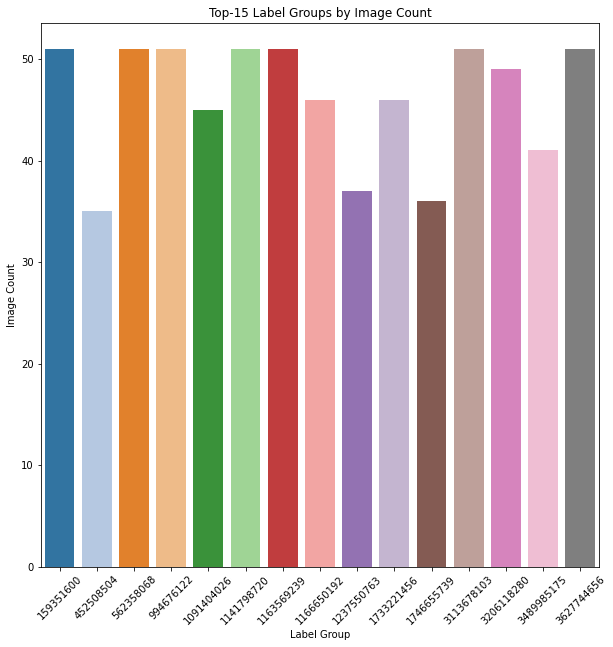

In [14]:
sns.set_palette("tab20")
top10_names = train_file['label_group'].value_counts().index.tolist()[:15]
top10_values = train_file['label_group'].value_counts().tolist()[:15]

plt.figure(figsize=(10, 10))
sns.barplot(x=top10_names, y=top10_values)
plt.xticks(rotation=45)
plt.xlabel("Label Group")
plt.ylabel("Image Count")
plt.title("Top-15 Label Groups by Image Count")
plt.show()

## Top-5 Products from Images

Let's see the top-5 products (by count of titles) in this dataset using their provided images.

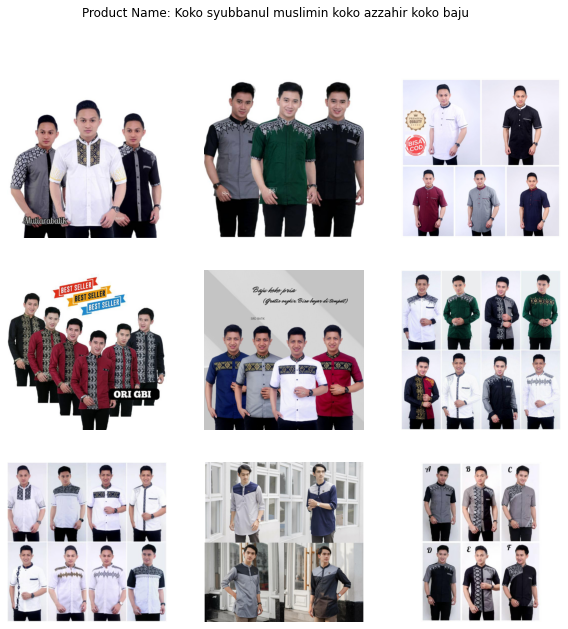

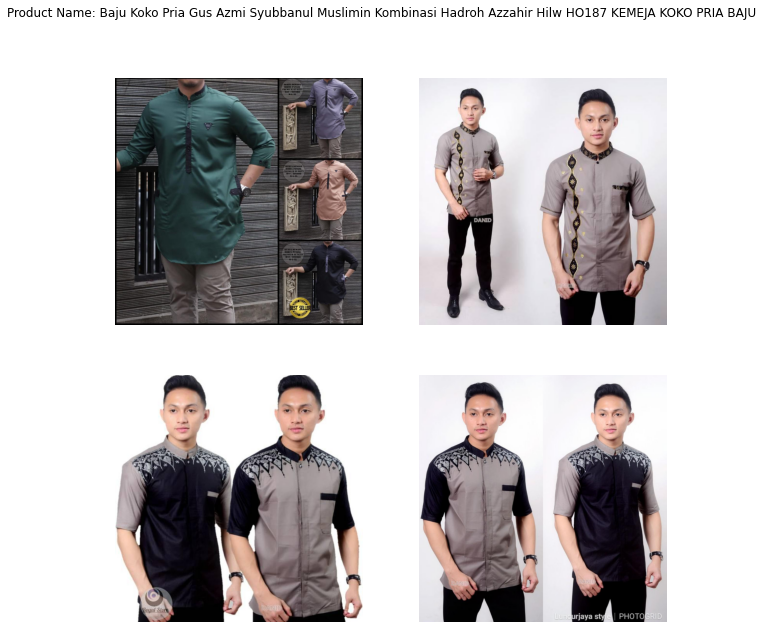

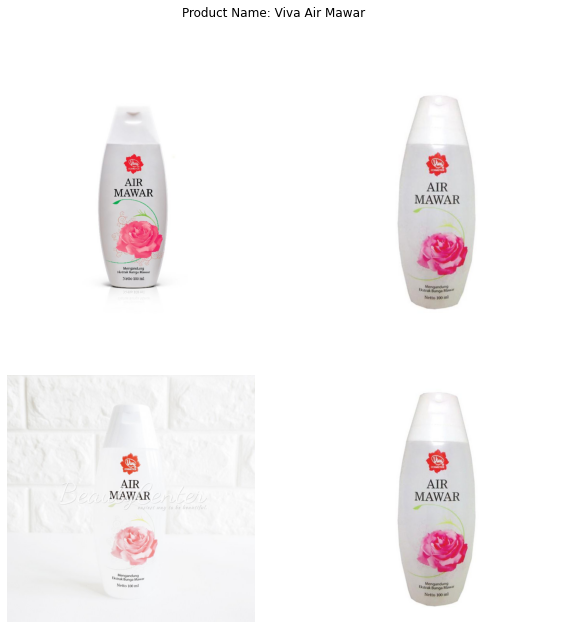

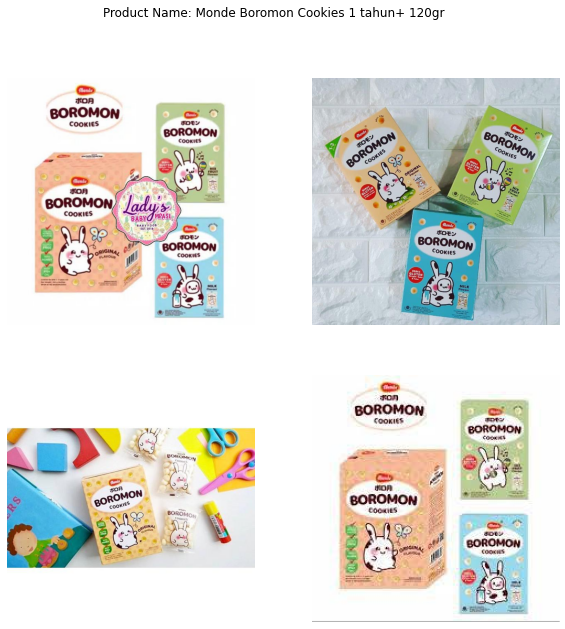

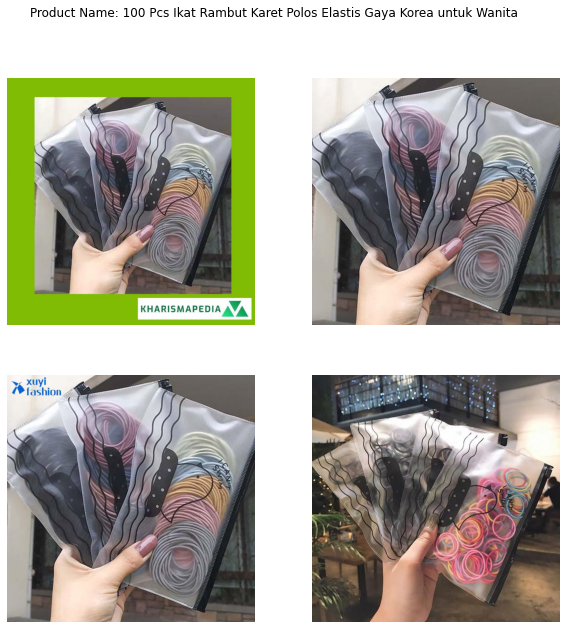

In [15]:
top5_products = train_file['title'].value_counts()[:5].index.tolist()
for title in top5_products:
    plot_from_title(title)

<hr>

In [16]:
cprint("[bold blue]UNDER WORK! MORE STUFF IS IN THE PROCESS OF BEING ADDED.[/bold blue]")

UNDER WORK! MORE STUFF IS IN THE PROCESS OF BEING ADDED.